<a href="https://colab.research.google.com/github/erzar0/engineering-thesis/blob/main/proof_of_concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Nov 19 15:23:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[('ca', 1.0), ('cu', 0.0), ('zn', 0.0), ('fe', 0.0), ('pb', 0.0), ('', 0.0), ('', 0.0), ('', 0.0), ('', 0.0), ('', 0.0)]


[[<matplotlib.lines.Line2D at 0x7a2fc4f93430>],

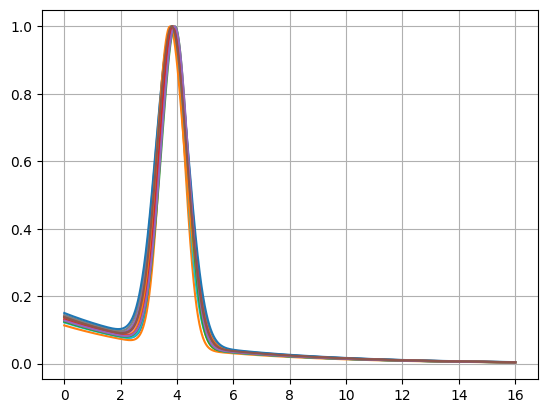

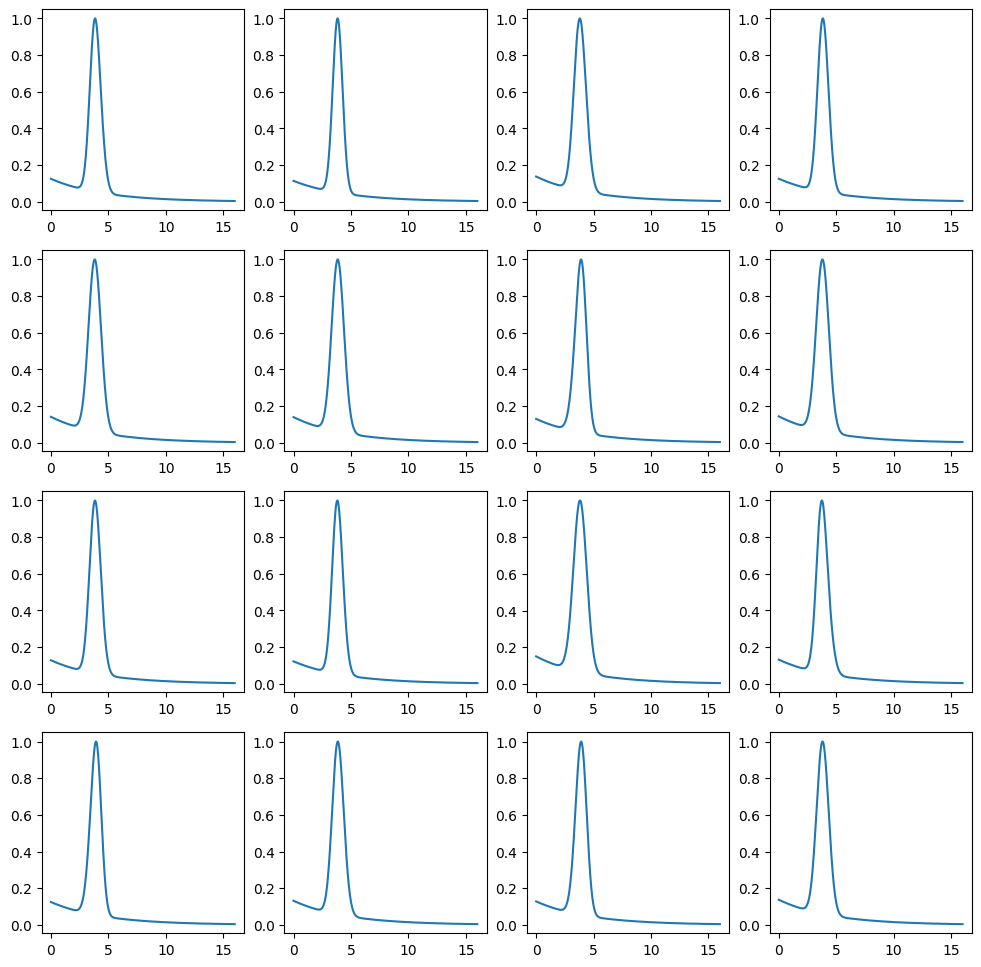

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from collections import defaultdict

plt.grid(True)

num2elem = defaultdict(str)
num2elem.update({
    0 : "ca"
    , 1 : "cu"
    , 2 : "zn"
    , 3 : "fe"
    , 4 : "pb"
})

element_lines = {
    0 : (("k_alpha", 3.69, 1), ("k_beta", 4.01, 1),)
    , 1 : (("k_alpha", 8.04, 1), ("k_beta", 8.91, 0.4))
    , 2 : (("k_alpha", 8.64, 1), ("k_beta", 9.57, 1))
    , 3 : (("k_alpha", 6.4, 1), ("k_beta", 7.06, 0.1))
    , 4 : (("l_alpha", 10.5, 1), ("l_beta", 12.6, 0.9), ("m_alpha", 2.82, 0.01), ("m_beta", 3.16, 0.01))
}

TARGET_VECTOR_LENGTH = 10
MIN_ENERGY = 0
MAX_ENERGY = 16
CHANNELS_COUNT = 4096
DETECTOR_BASE_SIGMA = 0.5
DETECTOR_SIGMA_COEF = 0.005

def gaussian(x, mu, sigma):
    return  np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def get_random_percentages(n):
    percentage_boundries = [0] + sorted([random.random() for _ in range(n - 1)]) + [1]
    return [percentage_boundries[i] - percentage_boundries[i-1] for i in range(1, len(percentage_boundries))]

def calculate_sigma(energy):
    return DETECTOR_BASE_SIGMA - energy * DETECTOR_SIGMA_COEF

def generate_training_data(element_lines, mu_max_err = 0.02, sigma_max_err = 0.05, samples = 10, elements_per_sample = 3, element_numbers = None):
    X = [np.zeros(CHANNELS_COUNT) for _ in range(samples)]
    y = [np.zeros(TARGET_VECTOR_LENGTH) for _ in range(samples)]
    linspace = np.linspace(MIN_ENERGY, MAX_ENERGY, CHANNELS_COUNT)

    for i in range(samples):
        if element_numbers is None:
            selected_element_numbers = random.sample(sorted(element_lines), elements_per_sample)
        else:
            selected_element_numbers = element_numbers
        element_percentages = get_random_percentages(len(selected_element_numbers))

        for element_percentage, element_number in zip(element_percentages, selected_element_numbers):
            y[i][element_number] = 1

            for element_line in element_lines[element_number]:
                mu = element_line[1] + np.random.uniform(-mu_max_err, mu_max_err)
                sigma = calculate_sigma(mu) + np.random.uniform(-sigma_max_err, sigma_max_err)
                # intensity = element_line[2]

                X[i] += gaussian(linspace, mu, sigma) * element_percentage

        X[i] += np.exp(-np.linspace(1.5, 5, CHANNELS_COUNT))
        X[i] /= np.max(X[i])

    return X, y

def print_y(target):
    percentages = defaultdict(float)
    for i in range(TARGET_VECTOR_LENGTH):
        percentages[i] = target[i]
    percentages = sorted(percentages.items(), key=lambda item: item[1], reverse=True)
    percentages = [(num2elem[k], v) if k in num2elem else ('', v) for k, v in percentages]
    print(percentages)

example_X, example_y = generate_training_data(element_lines, mu_max_err = 0.05, sigma_max_err = 0.08, samples=100,  elements_per_sample=3, element_numbers = [0])
example_X = np.asarray(example_X)
example_y = np.asarray(example_y)
print_y(example_y[0])

[plt.plot(np.linspace(0, 16, CHANNELS_COUNT), example_X[i*4 + j]) for i in range(4) for j in range(4)]

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
[axs[i][j].plot(np.linspace(0, 16, CHANNELS_COUNT), example_X[i*4 + j]) for i in range(4) for j in range(4)]


In [ ]:
!pip install graphviz
!apt-get install graphviz
!pip install torchview

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
import copy
import torch
import tqdm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from torchview import draw_graph
from graphviz import Source
from torch.utils.data import DataLoader, TensorDataset


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv1d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm1d(intermediate_channels)
        self.conv2 = nn.Conv1d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm1d(intermediate_channels)
        self.conv3 = nn.Conv1d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm1d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * 4, num_classes)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print(x.shape)

        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.shape)
        x = self.avgpool(x)
        # print(x.shape)

        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return self.sigmoid(x)

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv1d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm1d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(num_classes=TARGET_VECTOR_LENGTH, num_channels=1):
    return ResNet(block, [3, 4, 6, 3], num_channels, num_classes)

def test():
    BATCH_SIZE = 16
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet50(num_channels=1, num_classes=TARGET_VECTOR_LENGTH).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, CHANNELS_COUNT).to(device))
    assert y.size() == torch.Size([BATCH_SIZE, TARGET_VECTOR_LENGTH])
    print(y.size())



In [ ]:
!nvidia-smi

Sun Nov 19 15:23:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

(10000, 1, 4096)
(10000, 10)
Epoch 0
Batch 1, loss: 0.6728238463401794
Batch 2, loss: 0.5595418810844421
Batch 3, loss: 0.47697463631629944
Batch 4, loss: 0.4211033880710602
Batch 5, loss: 0.367197722196579
Batch 6, loss: 0.3478918969631195
Batch 7, loss: 0.31018075346946716
Batch 8, loss: 0.29188743233680725
Batch 9, loss: 0.27957215905189514
Batch 10, loss: 0.26334676146507263
Batch 11, loss: 0.2534444332122803
Batch 12, loss: 0.23540353775024414
Batch 13, loss: 0.2430761605501175
Batch 14, loss: 0.24922871589660645
Batch 15, loss: 0.22044554352760315
Batch 16, loss: 0.22746577858924866
Batch 17, loss: 0.23187212646007538
Batch 18, loss: 0.22429470717906952
Batch 19, loss: 0.22209607064723969
Batch 20, loss: 0.21178780496120453
Batch 21, loss: 0.20912261307239532
Batch 22, loss: 0.2160124033689499
Batch 23, loss: 0.2232523262500763
Batch 24, loss: 0.2053767740726471
Batch 25, loss: 0.204173281788826
Batch 26, loss: 0.21896444261074066
Batch 27, loss: 0.21753564476966858
Batch 28, los

AttributeError: ignored

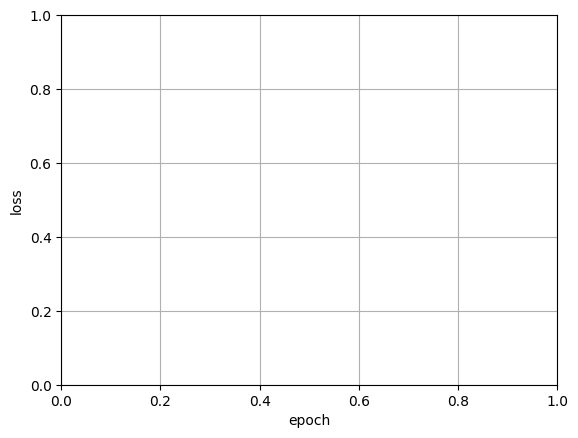

In [ ]:
from functools import reduce

def create_dataloader(X, y, device, batch_size=16, shuffle=True):
    X_train_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, train_loader, test_loader, optimizer, criterion, epochs = 3):
    best_loss = np.inf
    best_weights = None
    train_history = []
    test_history = []
    for epoch in range(epochs):
        model.train()
        print(f"Epoch {epoch}")
        train_loss = 0
        idx = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            idx += 1
            train_loss += float(loss)
            print(f"Batch {idx}, loss: {float(loss)}")

        train_loss = train_loss/idx
        print("train epoch avg loss: %.2f" % train_loss)
        train_history.append(train_loss)

        with torch.no_grad():
            model.eval()
            def _calc_loss(dataloader, test_batches=10):
                loss_acc = 0
                idx = 0
                for X_batch, y_batch in dataloader:
                    if idx == test_batches:
                        break
                    idx += 1

                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss_acc += float(loss)
                return loss_acc / idx

            test_loss = _calc_loss(test_loader)
            print("test loss: %.2f" % test_loss)
            test_history.append(test_loss)
            if test_loss < best_loss:
                best_loss = test_loss
                best_weights = copy.deepcopy(model.state_dict())

        print()
    return train_history, test_history, best_loss, best_weights



BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

artificial_data = [generate_training_data(element_lines, mu_max_err = 0.05, sigma_max_err = 0.08, samples = 2000,  elements_per_sample = i, element_numbers = None) for i in range(1, 6)]
X, y = reduce(lambda acc, val: (acc[0] + val[0], acc[1] + val[1]) ,artificial_data, ([], []))
X = np.asarray(X).reshape(-1, 1, CHANNELS_COUNT)
y = np.asarray(y)
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
train_loader = create_dataloader(X_train, y_train, DEVICE, batch_size=BATCH_SIZE, shuffle=True)
test_loader = create_dataloader(X_test, y_test, DEVICE, batch_size=BATCH_SIZE, shuffle=True)

model = ResNet50().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

train_history, test_history, best_loss, best_weights = train(model, train_loader, test_loader, optimizer, criterion, epochs = EPOCHS)

model.load_state_dict(best_weights)
print("loss: %.2f" % best_loss)

plt.grid(True)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(train_history, title="train avg loss")
plt.plot(test_history, title="test loss")
plt.show()

# model_graph = draw_graph(model, input_size=(batch_size, 1, 4096), device='meta')
# graph = model_graph.visual_graph
# graph.render("model_graph", format="svg", cleanup=True)

In [ ]:
!nvidia-smi

[('fe', 0.3370988070964813), ('cu', 0.32782065868377686), ('ca', 0.2340795248746872), ('zn', 0.10285353660583496), ('', 0.0006128509994596243), ('', 0.0004703155136667192), ('', 0.0002922391577158123), ('', 0.00029060602537356317), ('', 0.0002192623942391947), ('pb', 2.3278207663679495e-05)]
[('fe', 1.0), ('ca', 0.0), ('cu', 0.0), ('zn', 0.0), ('pb', 0.0), ('', 0.0), ('', 0.0), ('', 0.0), ('', 0.0), ('', 0.0)]


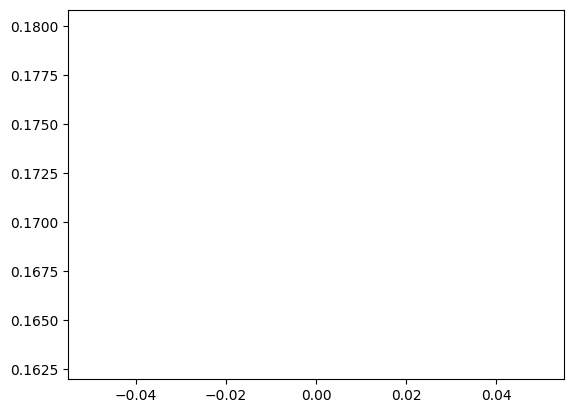

In [ ]:
N = 200
with torch.no_grad():
    y_pred = model(torch.tensor(X[N, 0].reshape((1, 1, 4096))).float().to(DEVICE))[0]
    print_y(y_pred.tolist())
    print_y(y[N].tolist())
    plt.plot(X[N, 0].tolist()[0])